In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from src.utils.data_utils import *
from src.utils.general_utils import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'
actors_career_path = 'data/Actor_career.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

with open(actors_career_path, 'rb') as file:
    Actor_career = pickle.load(file)

C:\Users\pierr\AppData\Local\Temp\ipykernel_22924\2221900138.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  Movie = pickle.load(file)


In [5]:
Actor["actor_age_atmovierelease"] = Actor["actor_age_atmovierelease"].apply(
    lambda x: [pd.NA if pd.isna(age) else int(age) for age in x]
)

Actor["actor_age_atmovierelease"] = Actor["actor_age_atmovierelease"].apply(
    lambda x: [-1 if (pd.isna(val) or val < 0) else val for val in x]
)

Actor["Career_Start_age"] = Actor.apply(
    lambda row: min([val for val in row["actor_age_atmovierelease"] if val > 0], default=-1),
    axis=1,
)


max_career_years = int(max(Actor.apply(lambda row: max(row["actor_age_atmovierelease"]),axis=1)-Actor["Career_Start_age"]))

Nbr_films = [f"Nbr_films_{i+1}" for i in range(100)]
Degree = [f"Degree_{i+1}" for i in range(100)]
Centrality = [f"Centrality_{i+1}" for i in range(100)]


Actor_career = pd.concat(
    [Actor.copy(), pd.DataFrame(0.0, index=Actor.index, columns=Nbr_films), pd.DataFrame(0.0, index=Actor.index, columns=Degree), pd.DataFrame(0.0, index=Actor.index, columns=Centrality)], axis=1)

In [6]:
def fill_career_years(row):

    age_at_release = np.array(row["actor_age_atmovierelease"])
    counts = np.zeros(max_career_years+1)
    
    if len(age_at_release) != 0:
        for year in age_at_release:
            if year >= 0 and row["Career_Start_age"]>=0:
                counts[year-row["Career_Start_age"]] += 1
                    
    return counts

In [39]:
start = time.time()

movie_releasedates = range(1920,2020) 
Actor_career['carrer_year'] = 0
career_counts = np.array(Actor_career.apply(fill_career_years, axis=1).tolist())

for i in range(max_career_years):
    Actor_career[f"Nbr_films_{i+1}"] = career_counts[:, i]


for date in tqdm(movie_releasedates):

    played_together = create_actor_network(Actor_career,Movie, min_movies=1, max_releasedate=date)

    nan_nodes = [node for node in played_together.nodes if pd.isna(node)]
    played_together.remove_nodes_from(nan_nodes)

    degrees = dict(played_together.degree())
    eigenvector_centrality = nx.eigenvector_centrality(played_together, max_iter=1000)
    eigenvector_values = np.array(list(eigenvector_centrality.values()))

    std = np.std(eigenvector_values)
    standardized_eigenvector_centrality = {node: val / std for node, val in eigenvector_centrality.items()}


    actor_id_to_idx = pd.Series(Actor_career.index, index=Actor_career["Freebase_actor_ID"]).to_dict()
    num_actors = len(Actor_career)
    degree_updates = np.zeros(num_actors, dtype=np.float32)
    centrality_updates = np.zeros(num_actors, dtype=np.float32)
    career_year_updates = np.zeros(num_actors, dtype=np.int32)


    for actor_id in played_together.nodes():
        if actor_id in actor_id_to_idx:
            actor_idx = actor_id_to_idx[actor_id]
            career_year = Actor_career.at[actor_idx, "carrer_year"]
            
            degree_updates[actor_idx] = degrees.get(actor_id, 0)
            centrality_updates[actor_idx] = standardized_eigenvector_centrality.get(actor_id, 0.0)
            career_year_updates[actor_idx] = career_year

            Actor_career.at[actor_idx, "carrer_year"] += 1


    for actor_idx, career_year in enumerate(career_year_updates):
        if career_year > 0:  # Only update valid career years
            Actor_career.at[actor_idx, f"Degree_{career_year}"] = degree_updates[actor_idx]
            Actor_career.at[actor_idx, f"Centrality_{career_year}"] = centrality_updates[actor_idx]


Actor_career.to_pickle('data/Actor_career.pkl')
print(f"Computation time: {time.time()-start:.2f}s")



100%|██████████| 100/100 [40:02<00:00, 24.03s/it]


Computation time: 2410.76s


In [114]:
columns_to_drop = ['Freebase_actor_ID', 'actor_name', 'actor_DOB', 'actor_gender','actor_height', 'ethnicity', 'Freebase_movie_ID','actor_age_atmovierelease', 'Career_Start_age']

Career_dataset = Actor_career.drop(columns=columns_to_drop, errors='ignore')


Career_dataset = Career_dataset.fillna(0)


means = Career_dataset.mean()
stddevs = Career_dataset.std()

Career_dataset_std = pd.DataFrame()

for c in Career_dataset.columns:
    Career_dataset[c] = (Career_dataset[c]-means[c])/stddevs[c]

Career_dataset = Career_dataset.fillna(0)


In [115]:
Career_dataset = Career_dataset.iloc[:,0:100]

In [116]:
Career_dataset

,Nbr_films_1,Nbr_films_2,Nbr_films_3,Nbr_films_4,Nbr_films_5,Nbr_films_6,Nbr_films_7,Nbr_films_8,Nbr_films_9,Nbr_films_10,...,Nbr_films_91,Nbr_films_92,Nbr_films_93,Nbr_films_94,Nbr_films_95,Nbr_films_96,Nbr_films_97,Nbr_films_98,Nbr_films_99,Nbr_films_100
0,2.660475,2.273360,6.933906,-0.224462,-0.219936,2.177318,-0.203936,-0.195809,-0.191466,2.397236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.972658,-0.231358,-0.233038,-0.224462,-0.219936,-0.213338,-0.203936,-0.195809,-0.191466,-0.183274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.972658,-0.231358,-0.233038,-0.224462,-0.219936,-0.213338,-0.203936,-0.195809,-0.191466,-0.183274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.972658,-0.231358,2.155943,-0.224462,2.129837,4.567973,2.197312,2.255143,4.751647,2.397236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.660475,2.273360,4.544925,4.392296,-0.219936,-0.213338,4.598561,7.157048,4.751647,2.397236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135755,-0.715159,-0.231358,-0.233038,-0.224462,-0.219936,-0.213338,-0.203936,-0.195809,-0.191466,-0.183274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135756,0.972658,-0.231358,-0.233038,-0.224462,-0.219936,-0.213338,-0.203936,-0.195809,-0.191466,-0.183274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135757,2.660475,-0.231358,-0.233038,-0.224462,-0.219936,-0.213338,-0.203936,-0.195809,-0.191466,2.397236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135758,0.972658,2.273360,-0.233038,-0.224462,4.479610,4.567973,6.999810,9.608001,7.223204,2.397236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1
2
3
4
5
6
7
8
9
10


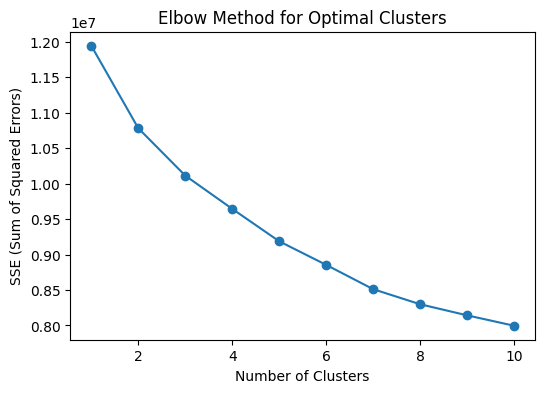

In [67]:
# Elbow method to determine the optimal number of clusters
sse = []
for k in range(1, 11):  # Test cluster numbers from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(Career_dataset)
    sse.append(kmeans.inertia_)
    print(k)

# Plot SSE
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), sse, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [117]:
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(Career_dataset)

In [118]:
Actor_career['Labels'] = labels

In [119]:
Actors_0 = Actor_career[Actor_career['Labels']==0]
Actors_1 = Actor_career[Actor_career['Labels']==1]
Actors_2 = Actor_career[Actor_career['Labels']==2]
Actors_3 = Actor_career[Actor_career['Labels']==3]
Actors_4 = Actor_career[Actor_career['Labels']==4]

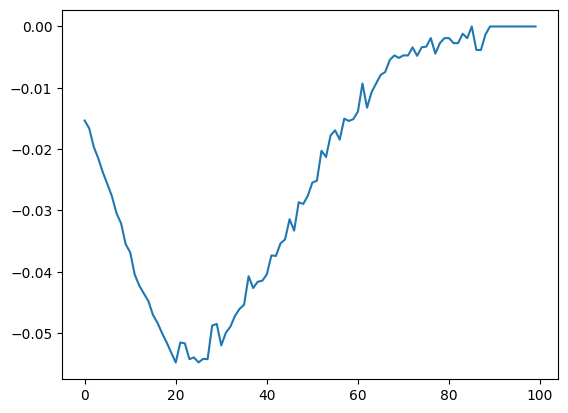

In [121]:
cluster_centers = kmeans.cluster_centers_
plt.plot(cluster_centers[0])

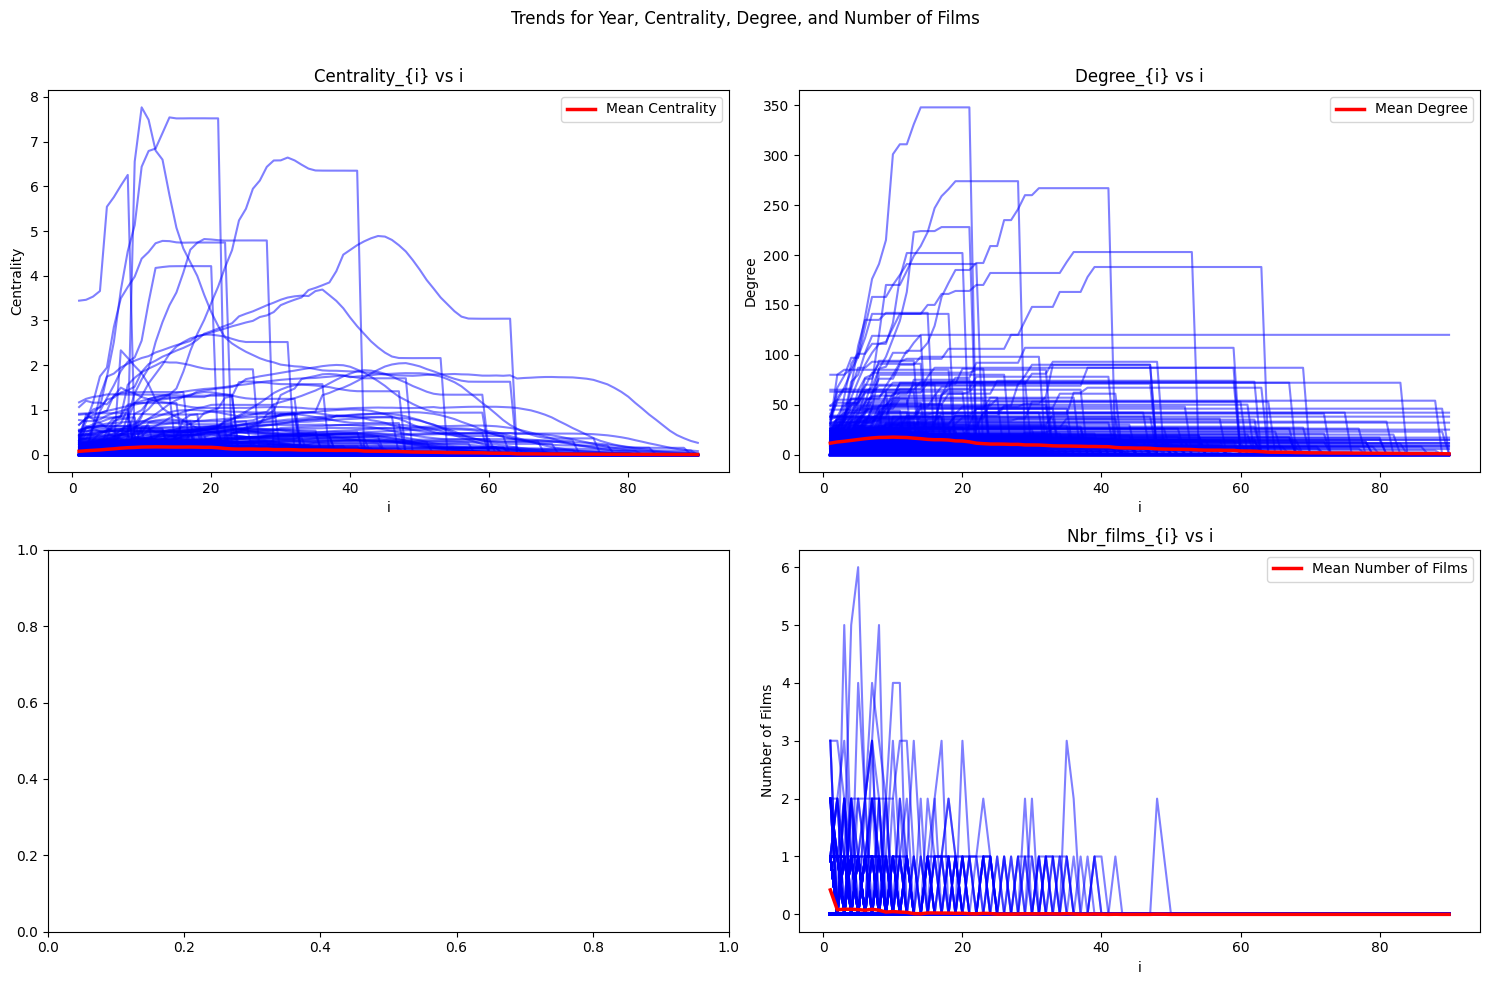

In [125]:
random_actors = Actors_0.sample(n=500)

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Trends for Year, Centrality, Degree, and Number of Films")

# X-axis: Range from 1 to 90
x = np.arange(1, 91)

# Compute mean curves
mean_centrality = random_actors[[f"Centrality_{i}" for i in range(1, 91)]].mean()
mean_degree = random_actors[[f"Degree_{i}" for i in range(1, 91)]].mean()
mean_nbr_films = random_actors[[f"Nbr_films_{i}" for i in range(1, 91)]].mean()

# Plot Centrality_{i}
for _, actor in random_actors.iterrows():
    axes[0, 0].plot(x, actor[[f"Centrality_{i}" for i in range(1, 91)]], alpha=0.5, color='blue')
axes[0, 0].plot(x, mean_centrality, color='red', linewidth=2.5, label="Mean Centrality")
axes[0, 0].set_title("Centrality_{i} vs i")
axes[0, 0].set_xlabel("i")
axes[0, 0].set_ylabel("Centrality")
axes[0, 0].legend()

# Plot Degree_{i}
for _, actor in random_actors.iterrows():
    axes[0, 1].plot(x, actor[[f"Degree_{i}" for i in range(1, 91)]], alpha=0.5, color='blue')
axes[0, 1].plot(x, mean_degree, color='red', linewidth=2.5, label="Mean Degree")
axes[0, 1].set_title("Degree_{i} vs i")
axes[0, 1].set_xlabel("i")
axes[0, 1].set_ylabel("Degree")
axes[0, 1].legend()

# Plot Nbr_films_{i}
for _, actor in random_actors.iterrows():
    axes[1, 1].plot(x, actor[[f"Nbr_films_{i}" for i in range(1, 91)]], alpha=0.5, color='blue')
axes[1, 1].plot(x, mean_nbr_films, color='red', linewidth=2.5, label="Mean Number of Films")
axes[1, 1].set_title("Nbr_films_{i} vs i")
axes[1, 1].set_xlabel("i")
axes[1, 1].set_ylabel("Number of Films")
axes[1, 1].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


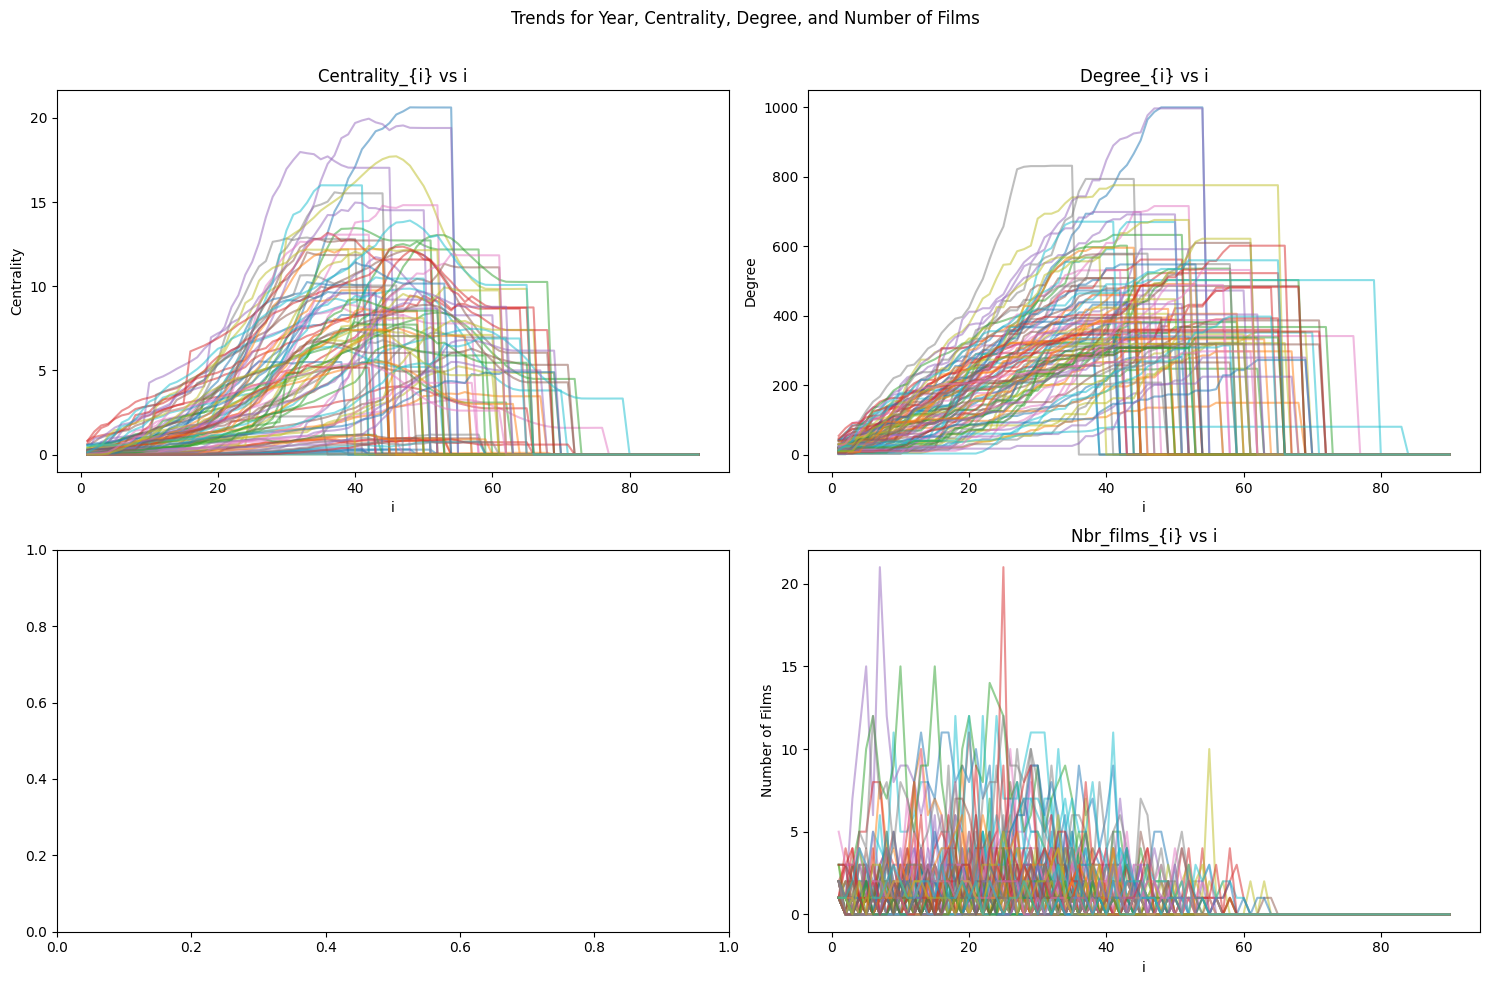

In [54]:
random_actors = Actors_1.sample(n=100)

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Trends for Year, Centrality, Degree, and Number of Films")

# X-axis: Range from 1 to 90
x = np.arange(1, 91)

# Plot Centrality_{i}
for _, actor in random_actors.iterrows():
    axes[0, 0].plot(x, actor[[f"Centrality_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 0].set_title("Centrality_{i} vs i")
axes[0, 0].set_xlabel("i")
axes[0, 0].set_ylabel("Centrality")

# Plot Degree_{i}
for _, actor in random_actors.iterrows():
    axes[0, 1].plot(x, actor[[f"Degree_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 1].set_title("Degree_{i} vs i")
axes[0, 1].set_xlabel("i")
axes[0, 1].set_ylabel("Degree")

# Plot Nbr_films_{i}
for _, actor in random_actors.iterrows():
    axes[1, 1].plot(x, actor[[f"Nbr_films_{i}" for i in range(1, 91)]], alpha=0.5)
axes[1, 1].set_title("Nbr_films_{i} vs i")
axes[1, 1].set_xlabel("i")
axes[1, 1].set_ylabel("Number of Films")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


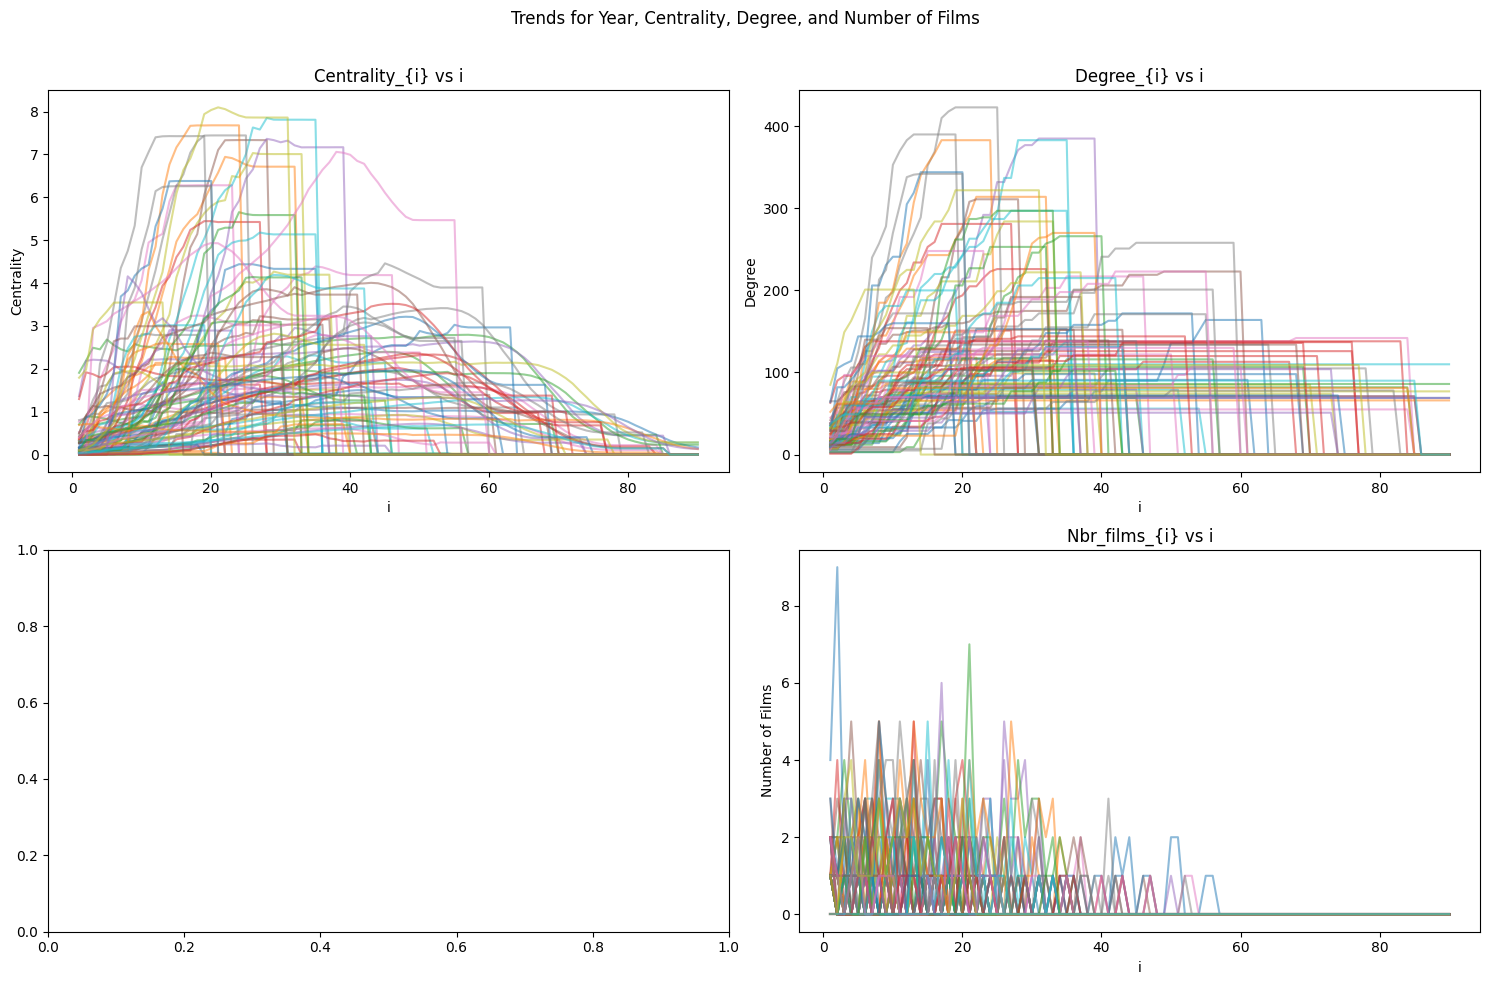

In [55]:
random_actors = Actors_2.sample(n=100)

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Trends for Year, Centrality, Degree, and Number of Films")

# X-axis: Range from 1 to 90
x = np.arange(1, 91)

# Plot Centrality_{i}
for _, actor in random_actors.iterrows():
    axes[0, 0].plot(x, actor[[f"Centrality_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 0].set_title("Centrality_{i} vs i")
axes[0, 0].set_xlabel("i")
axes[0, 0].set_ylabel("Centrality")

# Plot Degree_{i}
for _, actor in random_actors.iterrows():
    axes[0, 1].plot(x, actor[[f"Degree_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 1].set_title("Degree_{i} vs i")
axes[0, 1].set_xlabel("i")
axes[0, 1].set_ylabel("Degree")

# Plot Nbr_films_{i}
for _, actor in random_actors.iterrows():
    axes[1, 1].plot(x, actor[[f"Nbr_films_{i}" for i in range(1, 91)]], alpha=0.5)
axes[1, 1].set_title("Nbr_films_{i} vs i")
axes[1, 1].set_xlabel("i")
axes[1, 1].set_ylabel("Number of Films")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


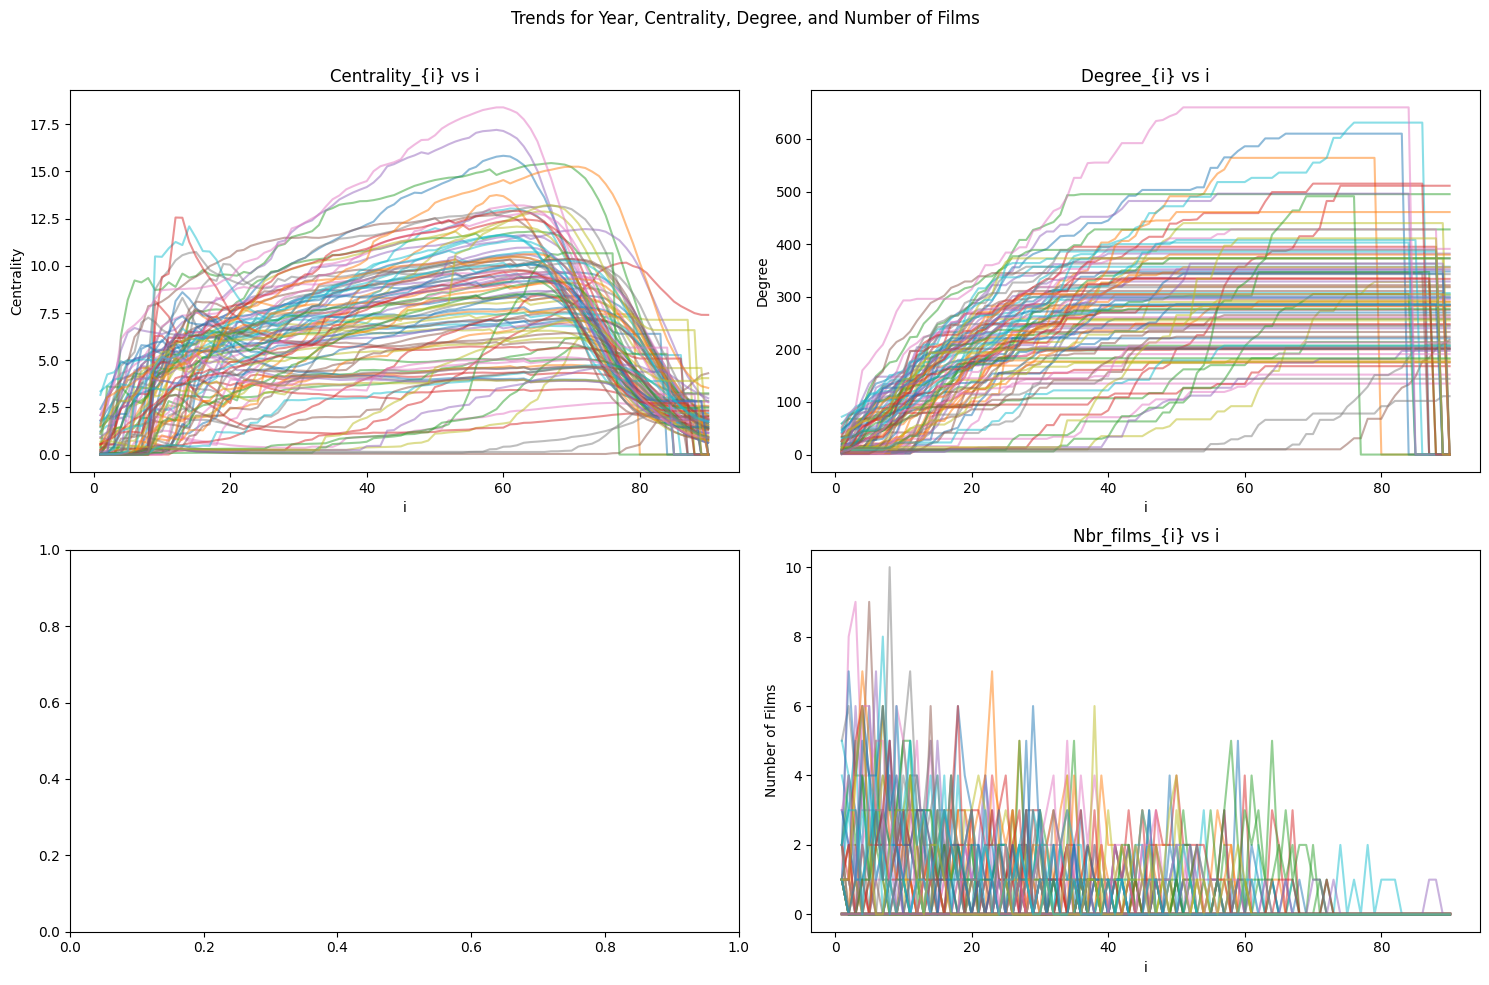

In [56]:
random_actors = Actors_3.sample(n=100)

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Trends for Year, Centrality, Degree, and Number of Films")

# X-axis: Range from 1 to 90
x = np.arange(1, 91)

# Plot Centrality_{i}
for _, actor in random_actors.iterrows():
    axes[0, 0].plot(x, actor[[f"Centrality_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 0].set_title("Centrality_{i} vs i")
axes[0, 0].set_xlabel("i")
axes[0, 0].set_ylabel("Centrality")

# Plot Degree_{i}
for _, actor in random_actors.iterrows():
    axes[0, 1].plot(x, actor[[f"Degree_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 1].set_title("Degree_{i} vs i")
axes[0, 1].set_xlabel("i")
axes[0, 1].set_ylabel("Degree")

# Plot Nbr_films_{i}
for _, actor in random_actors.iterrows():
    axes[1, 1].plot(x, actor[[f"Nbr_films_{i}" for i in range(1, 91)]], alpha=0.5)
axes[1, 1].set_title("Nbr_films_{i} vs i")
axes[1, 1].set_xlabel("i")
axes[1, 1].set_ylabel("Number of Films")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


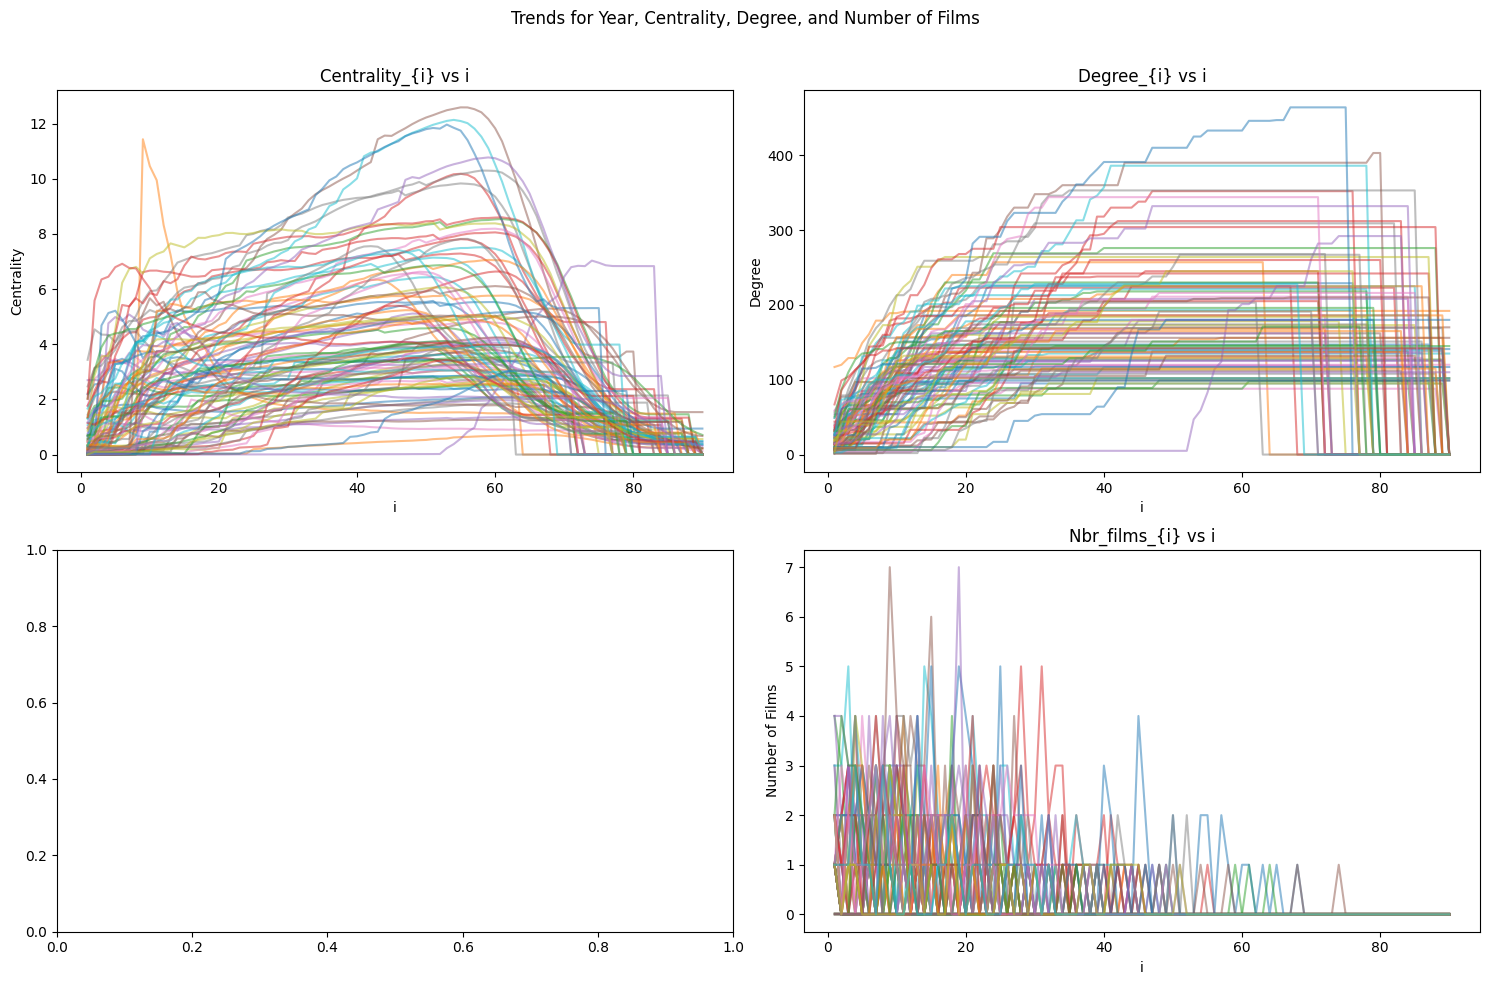

In [58]:
random_actors = Actors_4.sample(n=100)

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Trends for Year, Centrality, Degree, and Number of Films")

# X-axis: Range from 1 to 90
x = np.arange(1, 91)

# Plot Centrality_{i}
for _, actor in random_actors.iterrows():
    axes[0, 0].plot(x, actor[[f"Centrality_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 0].set_title("Centrality_{i} vs i")
axes[0, 0].set_xlabel("i")
axes[0, 0].set_ylabel("Centrality")

# Plot Degree_{i}
for _, actor in random_actors.iterrows():
    axes[0, 1].plot(x, actor[[f"Degree_{i}" for i in range(1, 91)]], alpha=0.5)
axes[0, 1].set_title("Degree_{i} vs i")
axes[0, 1].set_xlabel("i")
axes[0, 1].set_ylabel("Degree")

# Plot Nbr_films_{i}
for _, actor in random_actors.iterrows():
    axes[1, 1].plot(x, actor[[f"Nbr_films_{i}" for i in range(1, 91)]], alpha=0.5)
axes[1, 1].set_title("Nbr_films_{i} vs i")
axes[1, 1].set_xlabel("i")
axes[1, 1].set_ylabel("Number of Films")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
